# **DATA**

In [797]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf

### Downloading data

In [798]:
## Download raw data from yfinance
ticker = 'GLD'
print(f"Tải dữ liệu {ticker} từ yahoo finance.")
data = yf.download(ticker, start='2015-01-01', end='2025-10-01', progress=False, auto_adjust=False)
data.tail()

Tải dữ liệu GLD từ yahoo finance.


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GLD,GLD,GLD,GLD,GLD,GLD
Date,,,,,,
2025-09-24,343.320007,343.320007,346.829987,342.140015,346.700012,12709100
2025-09-25,344.750000,344.750000,345.829987,342.470001,344.390015,12639600
2025-09-26,346.739990,346.739990,348.250000,345.309998,345.829987,11698200
2025-09-29,352.459991,352.459991,352.829987,351.279999,351.790009,15719600
2025-09-30,355.470001,355.470001,355.570007,350.869995,351.130005,13312400


In [799]:
## Xử lý MultiIndex (Flatten Columns)
if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
data.head()

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2015-01-02,114.080002,114.080002,114.800003,112.320000,112.489998,7109600
2015-01-05,115.800003,115.800003,116.000000,114.730003,114.779999,8177400
2015-01-06,117.120003,117.120003,117.500000,115.800003,116.220001,11238300
2015-01-07,116.430000,116.430000,116.879997,116.169998,116.470001,6434200
2015-01-08,115.940002,115.940002,116.870003,115.849998,116.449997,7033700


In [800]:
df = data.copy()

### Cleaning Data

In [801]:
## Loại bỏ dữ liệu phi logic (Logically Inconsistent)
# Rule A: Volume không được âm
mask_vol = df['Volume'] >= 0

# Rule B: High phải lớn hơn hoặc bằng Low
mask_hl = df['High'] >= df['Low']

# Rule C: Close và Open phải nằm trong khoảng High-Low (chấp nhận sai số nhỏ do làm tròn)
epsilon = 1e-4 # Sửa lỗi làm tròn số khi code
mask_rng_close = (df['Close'] <= df['High'] + epsilon) & (df['Close'] >= df['Low'] - epsilon)
mask_rng_open  = (df['Open']  <= df['High'] + epsilon) & (df['Open']  >= df['Low'] - epsilon)

# Tổng hợp các dòng HỢP LỆ
valid_rows = mask_vol & mask_hl & mask_rng_close & mask_rng_open

# Đếm số dòng lỗi
invalid_count = len(df) - valid_rows.sum()
if invalid_count > 0:
    print(f"Phát hiện {invalid_count} dòng lỗi logic (trên dữ liệu gốc)")
    # In thử 1 dòng lỗi để kiểm tra xem có phải lỗi thật không
    # print("Ví dụ dòng lỗi:", df[~valid_rows].head(1))
    print('Đã loại bỏ dữ liệu phi logic.')
    df = df[valid_rows]
else:
    print('Không tồn tại dữ liệu phi logic.')

Không tồn tại dữ liệu phi logic.


In [802]:
## Chuẩn hóa tên cột
df['close'] = df['Adj Close']
df = df.rename(columns={
        'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume'
    })

# Chỉ giữ các cột OHLCV
required_cols = ['open', 'high', 'low', 'close', 'volume']
df = df[required_cols]

df.tail()

Price,open,high,low,close,volume
Date,,,,,
2025-09-24,346.700012,346.829987,342.140015,343.320007,12709100
2025-09-25,344.390015,345.829987,342.470001,344.750000,12639600
2025-09-26,345.829987,348.250000,345.309998,346.739990,11698200
2025-09-29,351.790009,352.829987,351.279999,352.459991,15719600
2025-09-30,351.130005,355.570007,350.869995,355.470001,13312400


In [803]:
# Missing Values
## LOCF (Last Observation Carried Forward)
df = df.ffill()
## Delete NaN data
df = df.dropna()

In [804]:
# Kiểm tra biến động cực đoan (Fat Tails Check)
# Không xóa blindly các outlier, chỉ flag.
# In cảnh báo nếu giá biến động > 20% một ngày để kiểm tra. (Kiểm tra có thể do sáp nhập M&A, Earning Suprise hoặc Flash Crash - Sập giá)
daily_ret = df['close'].pct_change().abs()
extreme_moves = daily_ret[daily_ret > 0.20] # Biến động > 20%

if not extreme_moves.empty:
    print(f"\n Phát hiện {len(extreme_moves)} ngày biến động giá > 20%.")
    print(extreme_moves.tail(3)) # In ra 3 ngày gần nhất

In [805]:
# Kiểm tra Volume = 0 (Thanh khoản kém)
# Thanh khoản thấp (Low Liquidity)
zero_vol_count = (df['volume'] == 0).sum()
if zero_vol_count > 0:
    print(f"Lưu ý: Có {zero_vol_count} ngày không có giao dịch (Volume=0).")
    # Với SMA nên giữ lại không xóa để tránh gãy chuỗi.

### Plotting

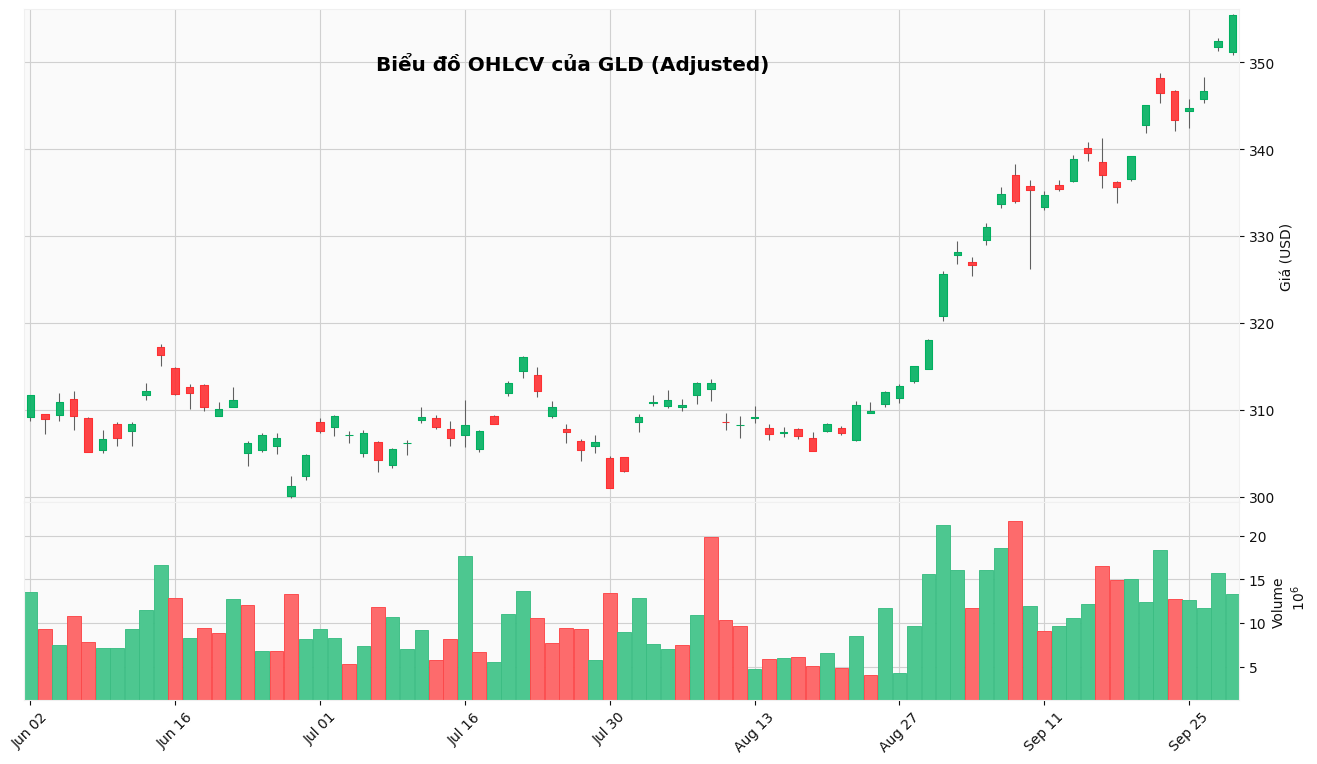

In [806]:
# Thiết lập giao diện (Style)
# 'yahoo': Phong cách giống Yahoo Finance (Nến xanh/đỏ)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 10})

# Vẽ biểu đồ
# type='candle': Biểu đồ nến
# volume=True: Hiển thị Volume bên dưới
df_short = df.loc['2025-06-01':'2025-10-01']
mpf.plot(df_short,
         type='candle',
         style=my_style,
         title=f'Biểu đồ OHLCV của {ticker} (Adjusted)',
         ylabel='Giá (USD)',
         ylabel_lower='Volume',
         volume=True,
         figsize=(14, 8),
         tight_layout=True)


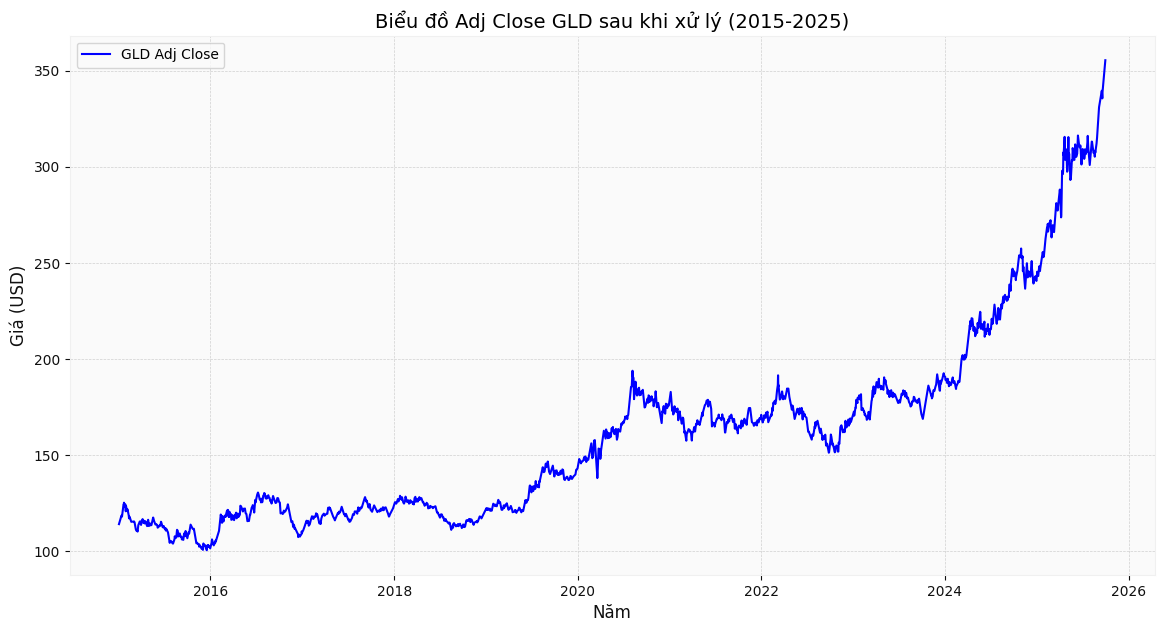

In [807]:
# Vẽ biểu đồ thể hiện Adj Close
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['close'], label=f'{ticker} Adj Close', color='blue', linewidth=1.5)

plt.title(f'Biểu đồ Adj Close {ticker} sau khi xử lý (2015-2025)', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

# **TREND-FOLLOWING SIGNAL**
## SMA (Simple Moving Average)
- The N-day SMA is the average close price of the past N days.
- Formula: $SMA_{N} = \frac{1}{N} \sum_{i=0}^{N-1} C_{t-i}$
- **Drawback:** It treats all prices of the past N days equally, failing to give more weight to recent data.

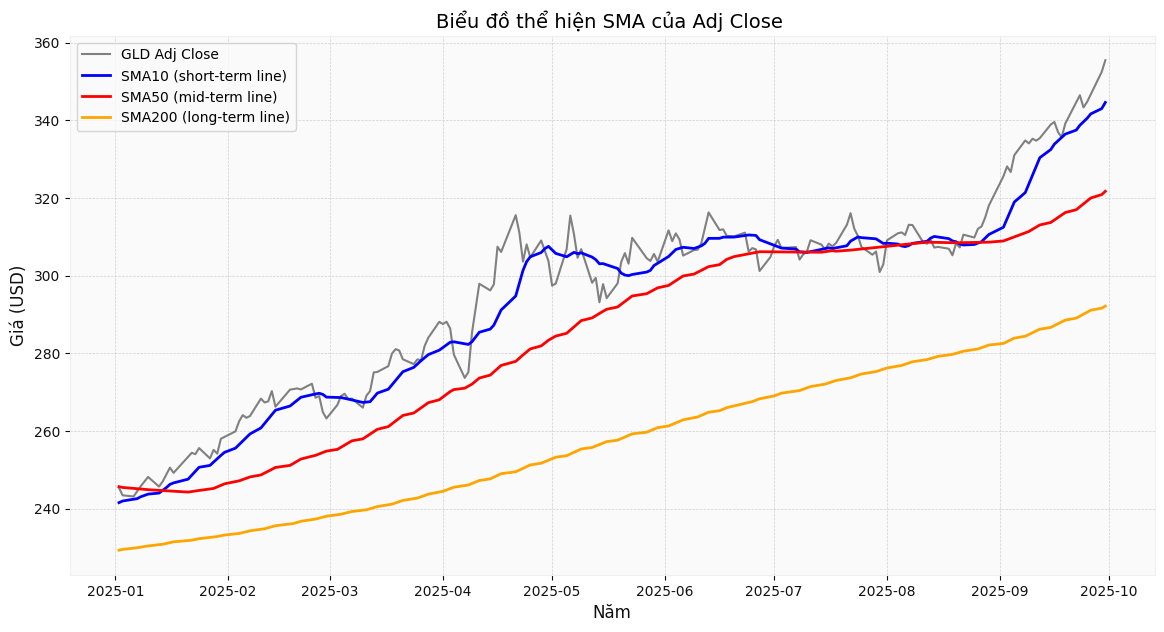

In [808]:
# Vẽ biểu đồ thể hiện SMA10 (short-term line), SMA50 (mid-term line), SMA200 (long-term line)

df['SMA_10'] = df['close'].rolling(window=10).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()

df_plot = df.loc['2025-01-01':'2025-10-30'].copy()

plt.figure(figsize=(14, 7))
plt.plot(df_plot.index, df_plot['close'], label=f'{ticker} Adj Close', color='gray', linewidth=1.5)
plt.plot(df_plot.index, df_plot['SMA_10'], label='SMA10 (short-term line)', color='blue', linewidth=2)
plt.plot(df_plot.index, df_plot['SMA_50'], label='SMA50 (mid-term line)', color='red', linewidth=2)
plt.plot(df_plot.index, df_plot['SMA_200'], label='SMA200 (long-term line)', color='orange', linewidth=2)

plt.title(f'Biểu đồ thể hiện SMA của Adj Close ', fontsize=14)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

- If the market closes above its 200-day SMA line, the market is in uptrend; if the market closes below its 200-day SMA line, the market is in downtrend

### Crossover Strategy
- Tín hiệu MUA (Long Entry): Khi đường SMA 50 (Short-term Line) cắt lên trên đường SMA 200 (Long-term line). Đây gọi là "Golden Cross", báo hiệu thị trường bước vào xu hướng tăng dài hạn.
- Tín hiệu BÁN/THOÁT (Exit/Short): Khi đường SMA 50 cắt xuống dưới đường SMA 200. Đây gọi là "Death Cross", báo hiệu xu hướng giảm.

In [809]:
def strategy_sma_crossover(data_input):
    df_sma = data_input.copy()

    # 1. Tính toán SMA50 và SMA200
    df_sma['SMA_50'] = df_sma['close'].rolling(window=50).mean()
    df_sma['SMA_200'] = df_sma['close'].rolling(window=200).mean()

    # 2. Tạo Tín hiệu (Signal)
    # Signal = 1 khi SMA_50 > SMA_200 (Giữ cổ phiếu - Mua cổ phiếu)
    # Signal = 0 khi SMA_50 <= SMA_200 (Giữ tiền mặt - Bán hết cổ phiếu)
    df_sma['Signal'] = 0
    df_sma.loc[df_sma['SMA_50'] > df_sma['SMA_200'], 'Signal'] = 1

    # 3. Tính Lợi nhuận Chiến lược (Strategy Returns)
    # Market Return: Lợi nhuận hàng ngày của cổ phiếu
    df_sma['Market_Return'] = df_sma['close'].pct_change()

    # Strategy Return: Lợi nhuận khi theo tín hiệu
    # shift(1) là quan trọng: Tín hiệu hôm nay dùng để giao dịch cho ngày mai (tránh look-ahead bias)
    df_sma['Strategy_Return'] = df_sma['Signal'].shift(1) * df_sma['Market_Return']

    # 4. Tính Lợi nhuận tích lũy (Cumulative Returns) - Lãi kép
    df_sma['Cumulative_Market'] = (1 + df_sma['Market_Return']).cumprod()
    df_sma['Cumulative_Strategy'] = (1 + df_sma['Strategy_Return']).cumprod()

    return df_sma

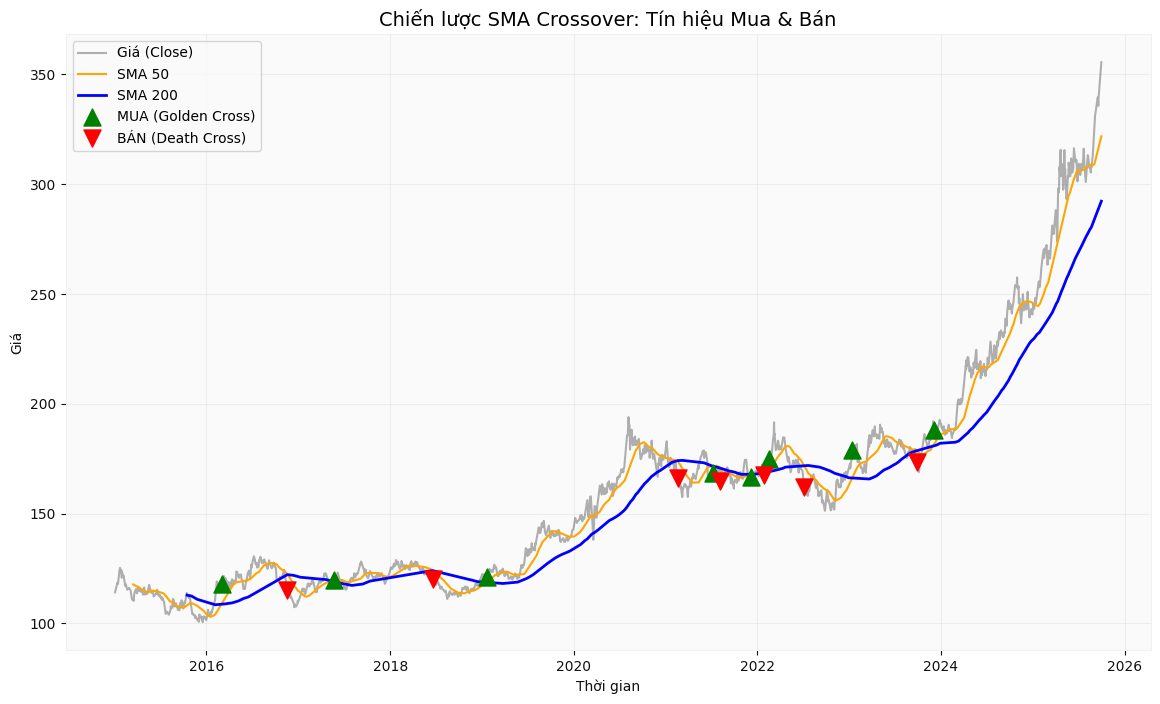

In [810]:
# --- PLOT SIGNAL TRADING ---

results = strategy_sma_crossover(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results['Position_Change'] = results['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals = results[results['Position_Change'] == 1]
sell_signals = results[results['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results.index, results['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results.index, results['SMA_50'], label='SMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results.index, results['SMA_200'], label='SMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals.index, buy_signals['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals.index, sell_signals['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược SMA Crossover: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

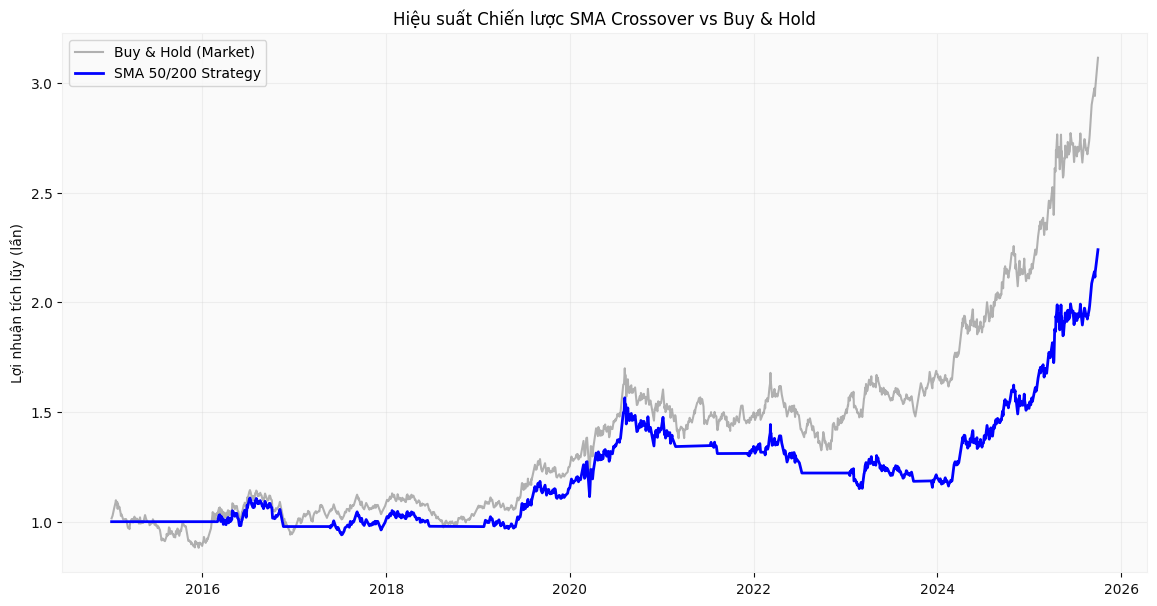

Lợi nhuận Buy & Hold: 211.60%
Lợi nhuận Chiến lược SMA: 124.06%


In [811]:
results = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='SMA 50/200 Strategy', color='blue', linewidth=2)

plt.title('Hiệu suất Chiến lược SMA Crossover vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy:.2%}")

Tại sao Chiến lược chỉ sử dụng SMA không hiệu quả?
- Độ trễ (The Cost of Lag): Khi thị trường đảo chiều tăng mạnh, SMA phản ứng chậm. Bắt đầu mua khi giá đã tăng một đoạn khá xa, bỏ lỡ đoạn lợi nhuận từ đáy.
- Tín hiệu giả (Whipsaws in Sideways Markets): Khi thị trường đi ngang (không rõ xu hướng), giá cứ cắt lên rồi lại cắt xuống liên tục. Bị "mua đỉnh bán đáy" liên tiếp (mua xong giá giảm, bán xong giá tăng), khiến tài khoản bị bào mòn dần bởi các khoản lỗ nhỏ.

Cách khắc khục Lags:
- Chuyển sang EMA (Exponential Moving Average) là bước nâng cấp đầu tiên để khắc phục nhược điểm "trọng số bình đẳng" (equal weighting) của SMA.
- Lý thuyết: EMA gán trọng số lớn hơn cho dữ liệu giá gần nhất, giúp đường trung bình phản ứng nhanh hơn với sự thay đổi của thị trường và giảm bớt độ trễ (lag)
- Formula: $$EMA_{t} = \alpha \times P_{t} + (1 - \alpha) \times EMA_{t-1}$$ với $$\alpha = \frac{2}{N + 1}$$

## FIX LAGS
### EMA (Exponential Moving Average)

In [812]:
def strategy_ema(df):
    """
    Chiến lược: MUA khi EMA ngắn hạn cắt lên EMA dài hạn.
    BÁN (Giữ tiền) khi EMA ngắn hạn cắt xuống.
    """
    df_ema = df.copy()

    # --- Tính Chỉ báo EMA ---
    # Dùng ewm (Exponential Weighted Functions) để tính EMA
    # adjust=False giúp tính đệ quy: EMA_t = alpha * Price + (1-alpha) * EMA_t-1
    df_ema['EMA_50'] = df_ema['close'].ewm(span=50, adjust=False).mean()
    df_ema['EMA_200'] = df_ema['close'].ewm(span=200, adjust=False).mean()

    # --- Tạo Tín hiệu (Signal) ---
    df_ema['Signal'] = 0
    # Điều kiện MUA: EMA Ngắn > EMA Dài
    df_ema.loc[df_ema['EMA_50'] > df_ema['EMA_200'], 'Signal'] = 1

    # Xác định điểm Mua/Bán để vẽ lên biểu đồ (diff: 1=Mua, -1=Bán)
    df_ema['Order'] = df_ema['Signal'].diff()

    # --- Tính Lợi nhuận ---
    # Lợi nhuận thị trường (Buy & Hold)
    df_ema['Market_Return'] = df_ema['close'].pct_change()

    # Lợi nhuận Chiến lược (Dùng tín hiệu hôm qua để giao dịch hôm nay -> shift(1))
    df_ema['Strategy_Return'] = df_ema['Signal'].shift(1) * df_ema['Market_Return']

    # Tính giá trị tài sản tích lũy (Bắt đầu từ 1 đồng)
    df_ema['Cumulative_Market'] = (1 + df_ema['Market_Return'].fillna(0)).cumprod()
    df_ema['Cumulative_Strategy'] = (1 + df_ema['Strategy_Return'].fillna(0)).cumprod()

    return df_ema

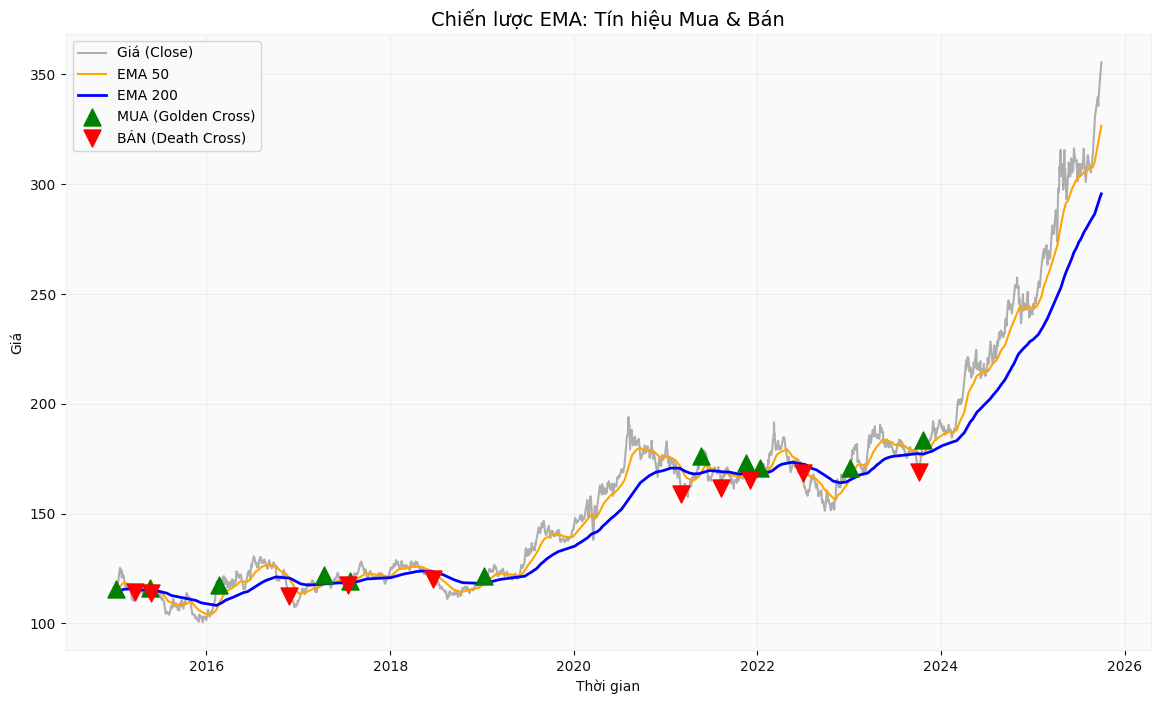

In [813]:
# --- PLOT SIGNAL TRADING ---

results2 = strategy_ema(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results2['Position_Change'] = results2['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals2 = results2[results2['Position_Change'] == 1]
sell_signals2 = results2[results2['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results2.index, results2['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results2.index, results2['EMA_50'], label='EMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results2.index, results2['EMA_200'], label='EMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals2.index, buy_signals2['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals2.index, sell_signals2['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược EMA: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

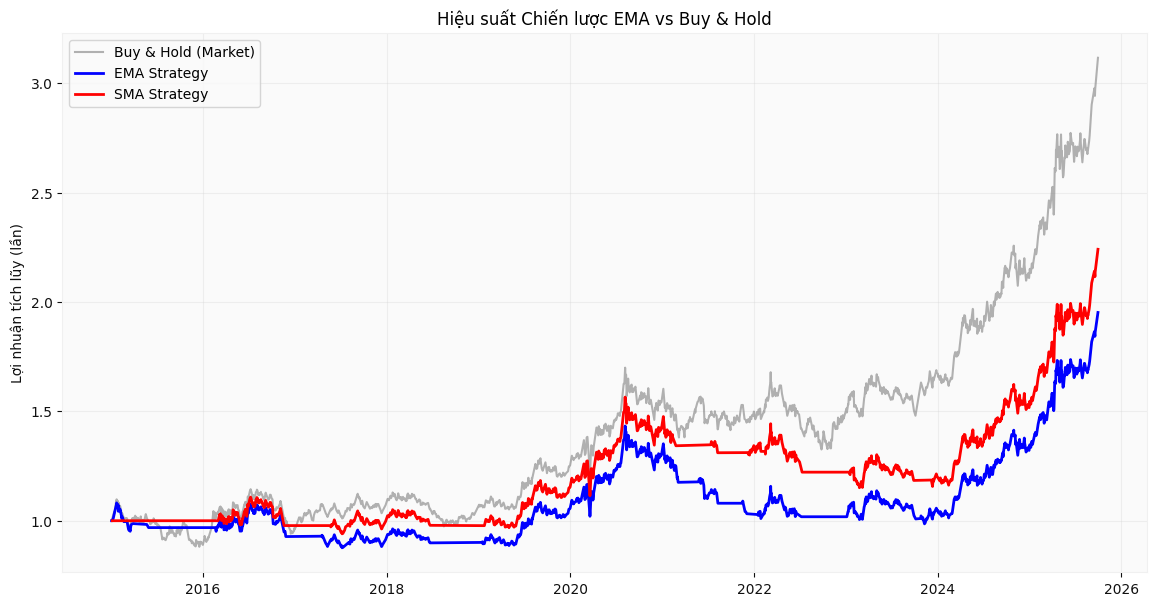

Lợi nhuận Buy & Hold: 211.60%
Lợi nhuận Chiến lược EMA: 95.18%
Lợi nhuận Chiến lược SMA: 124.06%


In [814]:
results = strategy_ema(df)
results2 = strategy_sma_crossover(df)

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='EMA Strategy', color='blue', linewidth=2)
plt.plot(results.index, results2['Cumulative_Strategy'], label='SMA Strategy', color='red', linewidth=2)

plt.title('Hiệu suất Chiến lược EMA vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
total_ret_strategy2 = results2['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược EMA: {total_ret_strategy:.2%}")
print(f"Lợi nhuận Chiến lược SMA: {total_ret_strategy2:.2%}")

Nếu xét về khả năng bảo vệ vốn khi thị trường sập (Bear Market) thì sao? Ta đi tính Max Drawdown để thấy rõ biểu hiện.

Max Drawdown (MDD) đo lường mức giảm phần trăm lớn nhất từ một đỉnh (Peak) xuống một đáy (Trough) xảy ra sau đó, trước khi một đỉnh mới được thiết lập.$$MDD = \min_{t \in (0, T)} \left( \frac{V_t - P_t}{P_t} \right)$$
Trong đó:
- $V_t$: Giá trị tài sản (Portfolio Value) tại thời điểm $t$.
- $P_t$: Giá trị đỉnh cao nhất đạt được trước thời điểm $t$ (Running Maximum).
$$P_t = \max_{\tau \in (0, t)} V_\tau$$

Chiến lược      | Max Drawdown (Rủi ro) | Lợi nhuận      
-------------------------------------------------------
Buy & Hold      | -22.00%                | 211.60%
SMA Strategy    | -26.47%                | 124.06%
EMA Strategy    | -31.22%                | 95.18%


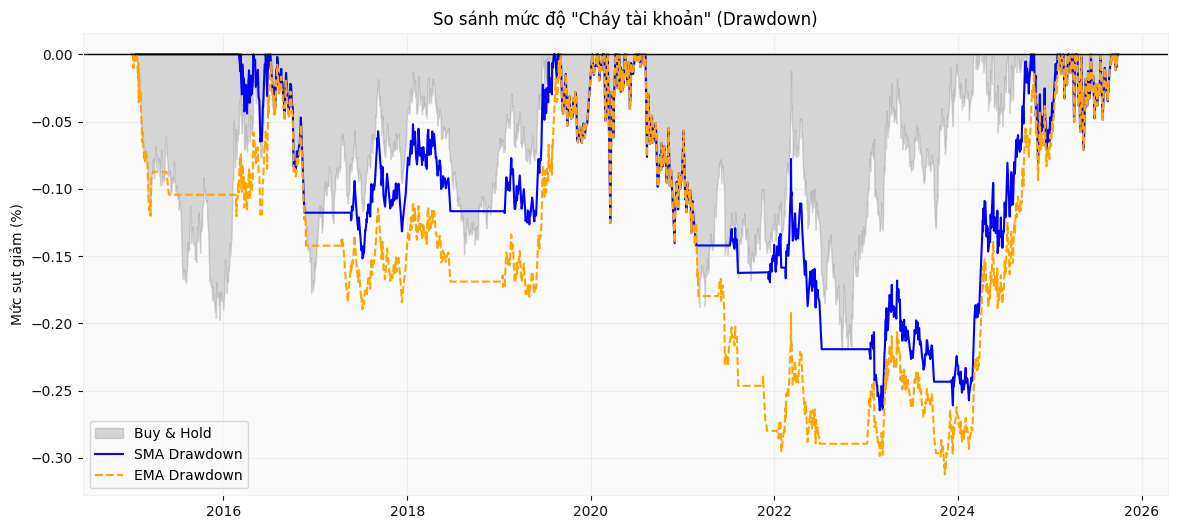

In [815]:

SHORT = 50
LONG = 200

# 1. Tính toán Chiến lược (SMA & EMA)
data = df.copy()
data['Ret'] = data['close'].pct_change() # Lợi nhuận hàng ngày của thị trường

# --- Chiến lược SMA ---
data['SMA_S'] = data['close'].rolling(window=SHORT).mean()
data['SMA_L'] = data['close'].rolling(window=LONG).mean()
data['Sig_SMA'] = np.where(data['SMA_S'] > data['SMA_L'], 1, 0)
data['Ret_SMA'] = data['Sig_SMA'].shift(1) * data['Ret'] # Lợi nhuận SMA

# --- Chiến lược EMA ---
data['EMA_S'] = data['close'].ewm(span=SHORT, adjust=False).mean()
data['EMA_L'] = data['close'].ewm(span=LONG, adjust=False).mean()
data['Sig_EMA'] = np.where(data['EMA_S'] > data['EMA_L'], 1, 0)
data['Ret_EMA'] = data['Sig_EMA'].shift(1) * data['Ret'] # Lợi nhuận EMA

# 2. Tính Tích lũy (Cumulative Return)
# Buy & Hold (Market)
data['Cum_Mkt'] = (1 + data['Ret'].fillna(0)).cumprod()
data['Cum_SMA'] = (1 + data['Ret_SMA'].fillna(0)).cumprod()
data['Cum_EMA'] = (1 + data['Ret_EMA'].fillna(0)).cumprod()

# 3. Tính Drawdown (Vùng sụt giảm)
def calc_dd(series):
    peak = series.cummax()
    return (series - peak) / peak

data['DD_Mkt'] = calc_dd(data['Cum_Mkt'])
data['DD_SMA'] = calc_dd(data['Cum_SMA'])
data['DD_EMA'] = calc_dd(data['Cum_EMA'])

# 4. In Kết quả So sánh
mdd_mkt = data['DD_Mkt'].min()
mdd_sma = data['DD_SMA'].min()
mdd_ema = data['DD_EMA'].min()

print(f"{'Chiến lược':<15} | {'Max Drawdown (Rủi ro)':<20} | {'Lợi nhuận':<15}")
print("-" * 55)
print(f"{'Buy & Hold':<15} | {mdd_mkt:.2%}                | {data['Cum_Mkt'].iloc[-1]-1:.2%}")
print(f"{'SMA Strategy':<15} | {mdd_sma:.2%}                | {data['Cum_SMA'].iloc[-1]-1:.2%}")
print(f"{'EMA Strategy':<15} | {mdd_ema:.2%}                | {data['Cum_EMA'].iloc[-1]-1:.2%}")

# 5. Vẽ Biểu đồ "Underwater" (So sánh độ sâu khi sập)
plt.figure(figsize=(14, 6))
plt.fill_between(data.index, data['DD_Mkt'], 0, color='gray', alpha=0.3, label='Buy & Hold')
plt.plot(data.index, data['DD_SMA'], color='blue', linewidth=1.5, label='SMA Drawdown')
plt.plot(data.index, data['DD_EMA'], color='orange', linewidth=1.5, linestyle='--', label='EMA Drawdown')

plt.title('So sánh mức độ "Cháy tài khoản" (Drawdown)')
plt.ylabel('Mức sụt giảm (%)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### DEMA (Double exponential moving average)
DEMA là một công thức toán học thông minh để cộng thêm vận tốc vào đường trung bình, giúp nó bắt kịp giá hiện tại (zero lag).
Formula:$$DEMA = 2 \times EMA_N - EMA(EMA_N)$$
Trong đó:
- $EMA_N$: Là đường EMA cấp 1 của giá (EMA thông thường).
- $EMA(EMA_N)$: Là đường EMA cấp 2 (Lấy đường EMA cấp 1 làm đầu vào để tính EMA tiếp lần nữa).
- $2 \times EMA_1 - EMA_2$: $EMA_2$ trễ hơn $EMA_1$.
- Hiệu số $(EMA_1 - EMA_2)$ đại diện cho "lỗi do độ trễ" (Lag error).
- Ta lấy $EMA_1$ cộng thêm phần lỗi này vào chính nó để "đẩy" đường chỉ báo về phía trước: $EMA_1 + (EMA_1 - EMA_2) = 2EMA_1 - EMA_2$.

In [816]:

def calculate_dema(series, span):

    # Tính EMA cấp 1
    ema1 = series.ewm(span=span, adjust=False).mean()
    # Tính EMA cấp 2 (EMA của EMA1)
    ema2 = ema1.ewm(span=span, adjust=False).mean()

    # Công thức khử trễ
    dema = 2 * ema1 - ema2
    return dema


def strategy_dema(df):
    data = df.copy()

    # --- A. TÍNH CHỈ BÁO ---
    # 1. Tính DEMA (Chiến lược chính)
    data['DEMA_50'] = calculate_dema(data['close'], span=50)
    data['DEMA_200'] = calculate_dema(data['close'], span=200)

    # --- B. TẠO TÍN HIỆU  ---
    data['Signal'] = 0
    # Mua khi DEMA Ngắn cắt lên DEMA Dài
    data.loc[data['DEMA_50'] > data['DEMA_200'], 'Signal'] = 1

    # --- C. TÍNH HIỆU SUẤT ---
    data['Market_Ret'] = data['close'].pct_change()
    data['Strategy_Ret'] = data['Signal'].shift(1) * data['Market_Ret']

    data['Cumulative_Market'] = (1 + data['Market_Ret'].fillna(0)).cumprod()
    data['Cumulative_Strategy'] = (1 + data['Strategy_Ret'].fillna(0)).cumprod()

    # Tính Drawdown
    peak = data['Cumulative_Strategy'].cummax()
    data['Drawdown'] = (data['Cumulative_Strategy'] - peak) / peak

    return data

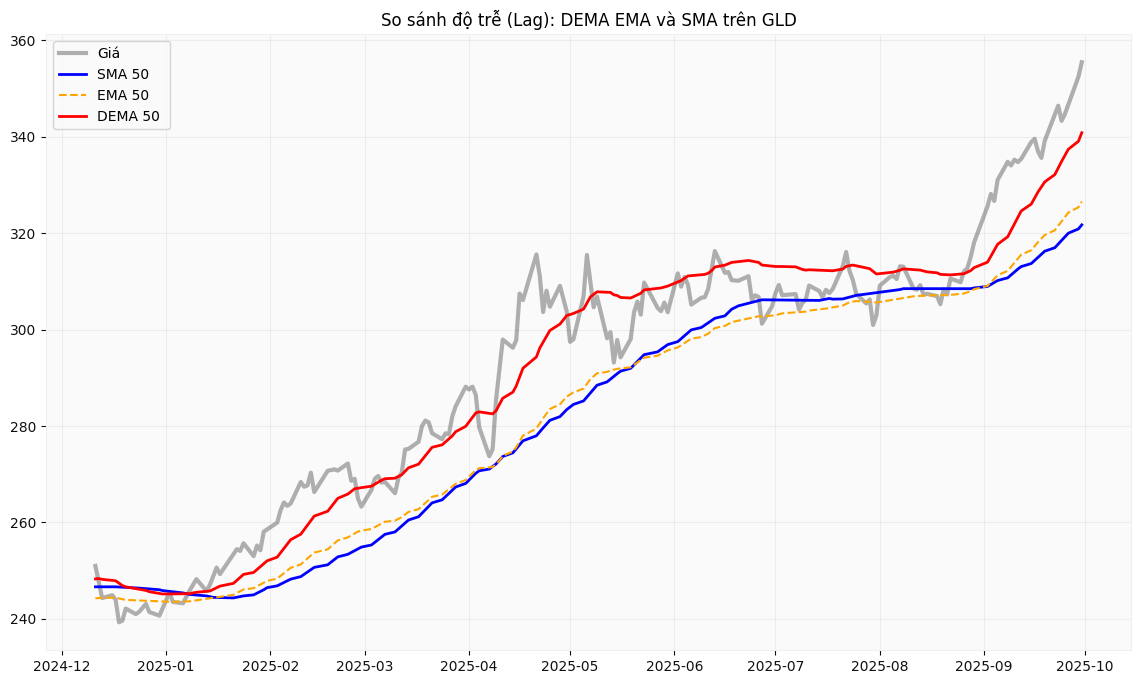

In [817]:
# --- VẼ BIỂU ĐỒ SO SÁNH ĐỘ TRỄ ---

results3 = strategy_sma_crossover(df)
results2 = strategy_ema(df)
results = strategy_dema(df)

subset = results.tail(200)
subset2 = results2.tail(200)
subset3 = results3.tail(200)
plt.figure(figsize=(14, 8))

# 1. Giá
plt.plot(subset.index, subset['close'], color='black', alpha=0.3, label='Giá', linewidth=3)

# 2. So sánh Short MA (50 ngày)
plt.plot(subset3.index, subset3['SMA_50'], color='blue', linewidth=2, label='SMA 50 ')
plt.plot(subset2.index, subset2['EMA_50'], color='orange', linestyle='--', label='EMA 50 ')
plt.plot(subset.index, subset['DEMA_50'], color='red', linewidth=2, label='DEMA 50 ')

plt.title(f'So sánh độ trễ (Lag): DEMA EMA và SMA trên {ticker}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


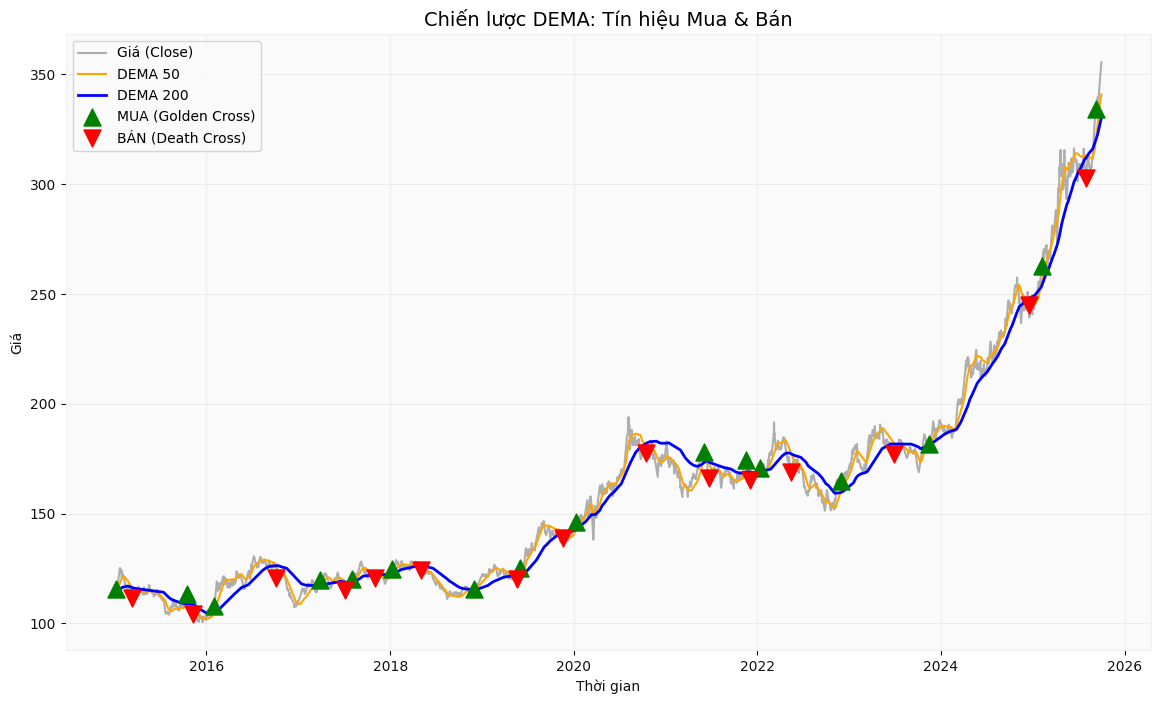

In [818]:
# --- PLOT SIGNAL TRADING ---

results = strategy_dema(df)

# Xác định điểm Mua và Bán
# Dùng hàm .diff() để tìm sự thay đổi của Signal
# diff = 1: Signal chuyển từ 0 lên 1 (MUA - Golden Cross)
# diff = -1: Signal chuyển từ 1 xuống 0 (BÁN - Death Cross)
results['Position_Change'] = results['Signal'].diff()

# Lọc ra các dòng có lệnh Mua/Bán
buy_signals = results[results['Position_Change'] == 1]
sell_signals = results[results['Position_Change'] == -1]

# 3. Vẽ biểu đồ
plt.figure(figsize=(14, 8))


plt.plot(results.index, results['close'], label='Giá (Close)', color='black', alpha=0.3)
# Vẽ SMA 50 (Ngắn hạn - Màu cam)
plt.plot(results.index, results['DEMA_50'], label='DEMA 50', color='orange', linewidth=1.5)
# Vẽ SMA 200 (Dài hạn - Màu xanh dương)
plt.plot(results.index, results['DEMA_200'], label='DEMA 200', color='blue', linewidth=2)


plt.scatter(buy_signals.index, buy_signals['close'],
            marker='^', color='green', s=150, zorder=5, label='MUA (Golden Cross)')
plt.scatter(sell_signals.index, sell_signals['close'],
            marker='v', color='red', s=150, zorder=5, label='BÁN (Death Cross)')

plt.title('Chiến lược DEMA: Tín hiệu Mua & Bán', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)

plt.show()

### Backtest

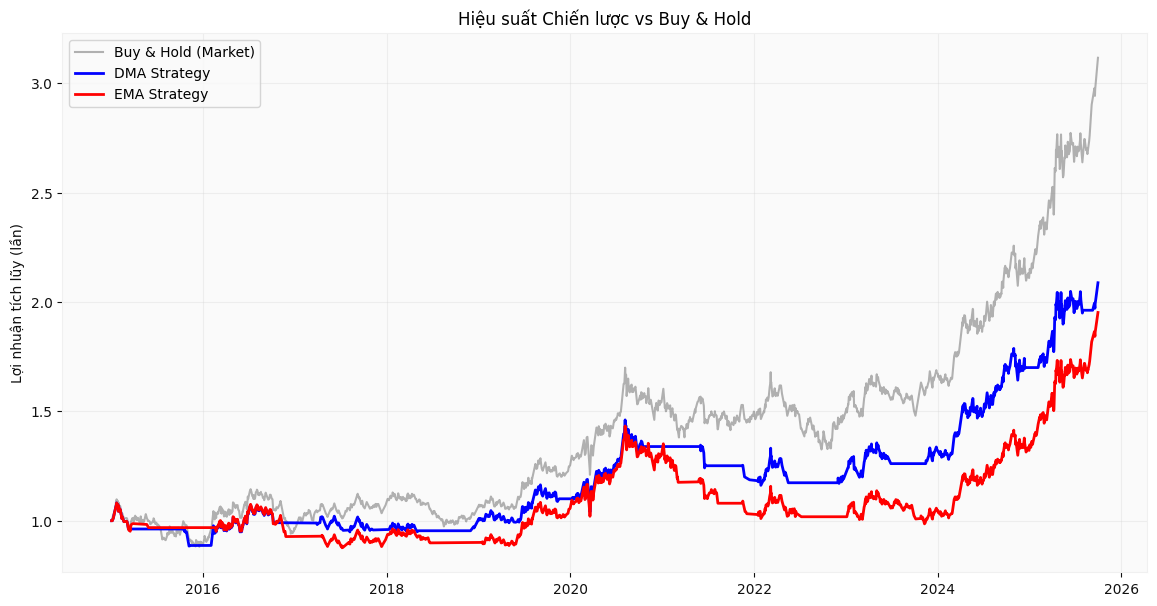

Lợi nhuận Buy & Hold: 211.60%
Lợi nhuận Chiến lược DMA: 108.78%
Lợi nhuận Chiến lược EMA: 95.18%


In [819]:
results = strategy_dema(df)
results2 = strategy_ema(df)


# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 7))
plt.plot(results.index, results2['Cumulative_Market'], label='Buy & Hold (Market)', color='gray', alpha=0.6)
plt.plot(results.index, results['Cumulative_Strategy'], label='DMA Strategy', color='blue', linewidth=2)
plt.plot(results.index, results2['Cumulative_Strategy'], label='EMA Strategy', color='red', linewidth=2)

plt.title('Hiệu suất Chiến lược vs Buy & Hold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylabel('Lợi nhuận tích lũy (lần)')
plt.show()

# In thống kê cuối cùng
total_ret_market = results['Cumulative_Market'].iloc[-1] - 1
total_ret_strategy = results['Cumulative_Strategy'].iloc[-1] - 1
total_ret_strategy2 = results2['Cumulative_Strategy'].iloc[-1] - 1
print(f"Lợi nhuận Buy & Hold: {total_ret_market:.2%}")
print(f"Lợi nhuận Chiến lược DMA: {total_ret_strategy:.2%}")
print(f"Lợi nhuận Chiến lược EMA: {total_ret_strategy2:.2%}")

Vì bám quá sát, DEMA cực kỳ nhạy cảm với mọi rung lắc nhỏ của thị trường.
Hậu quả: Khi thị trường Đi ngang (Sideways) hoặc không rõ xu hướng, giá cứ lên xuống nhẹ là DEMA đã cắt nhau loạn xạ.Do đó sẽ tạo ra nhiều tín hiệu giả (whipsaw): Mua xong giá giảm, Bán xong giá tăng. Tài khoản bị bào mòn bởi phí giao dịch và các khoản lỗ nhỏ liên tiếp. Thế nên cần biết thời điểm nào hợp lý để chiến lược được thực thi.

Chiến lược           | Max Drawdown (Rủi ro)     | Lợi nhuận cuối 
-----------------------------------------------------------------
Buy & Hold           | -22.00% (Thị trường)      | 211.60%
EMA Strategy         | -31.22% (Trễ hơn)         | 95.18%
DEMA Strategy        | -20.47% (Nhạy hơn)        | 108.78%


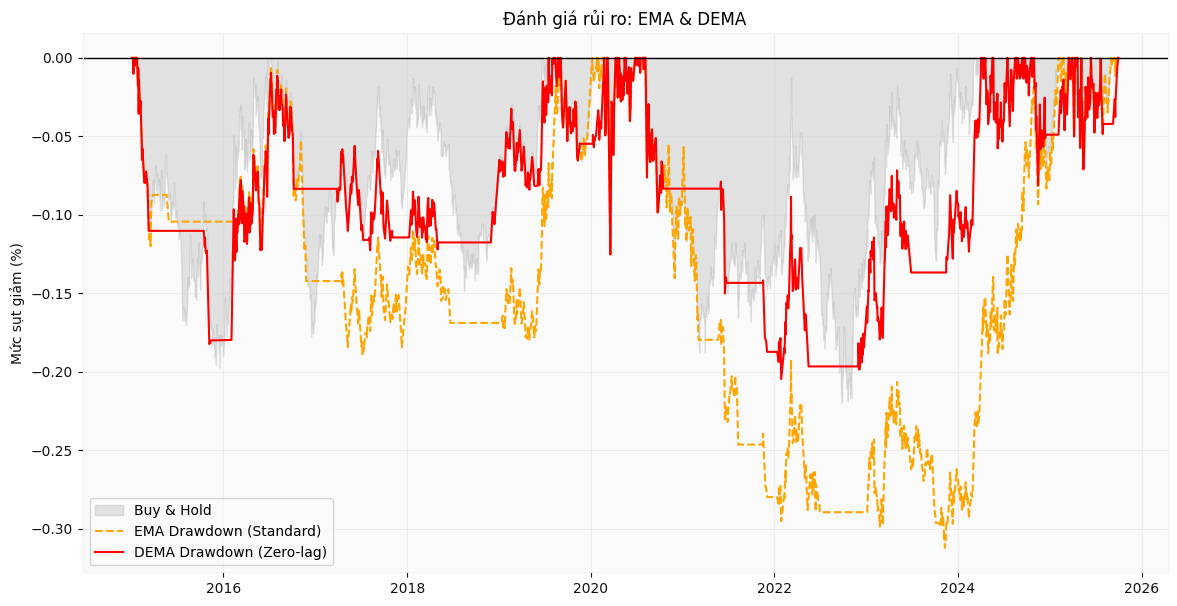

In [820]:

SHORT = 50
LONG = 200

# Hàm phụ trợ tính DEMA
def get_dema(series, span):
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

# 1. Tính toán Chiến lược
data = df.copy()
data['Ret'] = data['close'].pct_change() # Lợi nhuận thị trường

# --- Chiến lược EMA (Tiêu chuẩn) ---
data['EMA_S'] = data['close'].ewm(span=SHORT, adjust=False).mean()
data['EMA_L'] = data['close'].ewm(span=LONG, adjust=False).mean()
data['Sig_EMA'] = np.where(data['EMA_S'] > data['EMA_L'], 1, 0)
data['Ret_EMA'] = data['Sig_EMA'].shift(1) * data['Ret']

# --- Chiến lược DEMA (Zero-lag) ---
data['DEMA_S'] = get_dema(data['close'], span=SHORT)
data['DEMA_L'] = get_dema(data['close'], span=LONG)
data['Sig_DEMA'] = np.where(data['DEMA_S'] > data['DEMA_L'], 1, 0)
data['Ret_DEMA'] = data['Sig_DEMA'].shift(1) * data['Ret']

# 2. Tính Tích lũy & Drawdown
# Buy & Hold (để làm nền tham chiếu)
data['Cum_Mkt'] = (1 + data['Ret'].fillna(0)).cumprod()
data['Cum_EMA'] = (1 + data['Ret_EMA'].fillna(0)).cumprod()
data['Cum_DEMA'] = (1 + data['Ret_DEMA'].fillna(0)).cumprod()

def calc_dd(series):
    peak = series.cummax()
    return (series - peak) / peak

data['DD_Mkt'] = calc_dd(data['Cum_Mkt'])
data['DD_EMA'] = calc_dd(data['Cum_EMA'])
data['DD_DEMA'] = calc_dd(data['Cum_DEMA'])

# 3. In Kết quả So sánh
mdd_mkt = data['DD_Mkt'].min()
mdd_ema = data['DD_EMA'].min()
mdd_dema = data['DD_DEMA'].min()

print(f"{'Chiến lược':<20} | {'Max Drawdown (Rủi ro)':<25} | {'Lợi nhuận cuối':<15}")
print("-" * 65)
print(f"{'Buy & Hold':<20} | {mdd_mkt:.2%} (Thị trường)      | {data['Cum_Mkt'].iloc[-1]-1:.2%}")
print(f"{'EMA Strategy':<20} | {mdd_ema:.2%} (Trễ hơn)         | {data['Cum_EMA'].iloc[-1]-1:.2%}")
print(f"{'DEMA Strategy':<20} | {mdd_dema:.2%} (Nhạy hơn)        | {data['Cum_DEMA'].iloc[-1]-1:.2%}")

# 4. Vẽ Biểu đồ "Underwater" (So sánh độ sâu khi sập)
plt.figure(figsize=(14, 7))

# Vẽ nền Buy & Hold mờ để tham chiếu
plt.fill_between(data.index, data['DD_Mkt'], 0, color='gray', alpha=0.2, label='Buy & Hold')

# So sánh EMA và DEMA
plt.plot(data.index, data['DD_EMA'], color='orange', linewidth=1.5, linestyle='--', label='EMA Drawdown (Standard)')
plt.plot(data.index, data['DD_DEMA'], color='red', linewidth=1.5, label='DEMA Drawdown (Zero-lag)')

plt.title('Đánh giá rủi ro: EMA & DEMA')
plt.ylabel('Mức sụt giảm (%)')
plt.axhline(0, color='black', lw=1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## WHIPSAWS
- Giảm độ trễ (Lag) $\rightarrow$ Tăng độ nhiễu (Noise/Whipsaw)
- DEMA được tạo ra để triệt tiêu độ trễ $\rightarrow$ Hệ quả tất yếu là nó cực kỳ ồn (Noisy)
- Hiện tượng DEMA cắt lên cắt xuống liên tục là "Chatter" (Sự rung lắc của tín hiệu).

### ADX

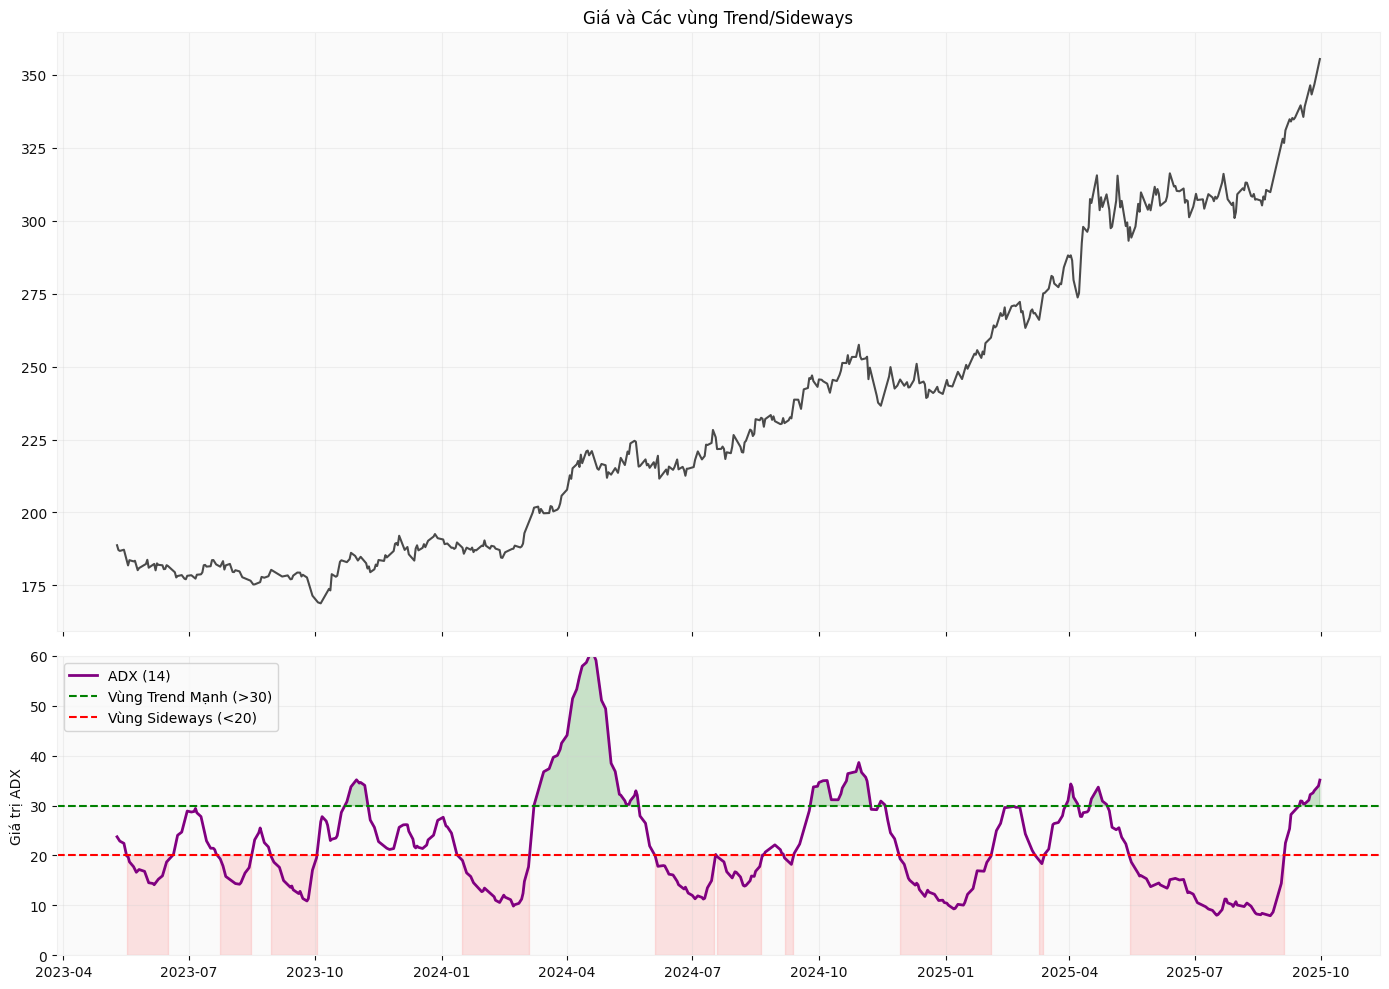

In [821]:
def calculate_adx_wilder(df, window=14):
    """
    Tính ADX theo công thức chuẩn của J. Welles Wilder.
    """
    data = df.copy()

    # 1. Tính True Range (TR) và Directional Movement (DM)
    data['H-L'] = data['high'] - data['low']
    data['H-PC'] = abs(data['high'] - data['close'].shift(1))
    data['L-PC'] = abs(data['low'] - data['close'].shift(1))

    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    data['UpMove'] = data['high'] - data['high'].shift(1)
    data['DownMove'] = data['low'].shift(1) - data['low']

    data['+DM'] = np.where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), data['UpMove'], 0)
    data['-DM'] = np.where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), data['DownMove'], 0)

    # 2. Hàm làm mượt Wilder (Wilder's Smoothing)
    # Công thức: Smooth_t = (Smooth_t-1 * (n-1) + Value_t) / n
    # Tương đương với ewm(alpha=1/n)
    alpha = 1 / window

    data['TR_Smooth'] = data['TR'].ewm(alpha=alpha, adjust=False).mean()
    data['+DM_Smooth'] = data['+DM'].ewm(alpha=alpha, adjust=False).mean()
    data['-DM_Smooth'] = data['-DM'].ewm(alpha=alpha, adjust=False).mean()

    # 3. Tính DI (+DI và -DI)
    data['+DI'] = 100 * (data['+DM_Smooth'] / data['TR_Smooth'])
    data['-DI'] = 100 * (data['-DM_Smooth'] / data['TR_Smooth'])

    # 4. Tính DX và ADX
    data['DX'] = 100 * abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])
    data['ADX'] = data['DX'].ewm(alpha=alpha, adjust=False).mean()

    return data

# --- VẼ BIỂU ĐỒ MINH HỌA ---
try:
    # Tính ADX
    df_adx = calculate_adx_wilder(df)

    # Lấy 300 ngày gần nhất để xem cho rõ
    subset = df_adx.tail(600)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

    # Biểu đồ Giá
    ax1.plot(subset.index, subset['close'], color='black', alpha=0.7, label='Giá')
    ax1.set_title('Giá và Các vùng Trend/Sideways')
    ax1.grid(True, alpha=0.3)

    # Biểu đồ ADX
    ax2.plot(subset.index, subset['ADX'], color='purple', linewidth=2, label='ADX (14)')

    # Vẽ ngưỡng 20 và 30
    ax2.axhline(30, color='green', linestyle='--', label='Vùng Trend Mạnh (>30)')
    ax2.axhline(20, color='red', linestyle='--', label='Vùng Sideways (<20)')

    # Tô màu nền để phân biệt chế độ
    # Màu Xanh: Trend Mode (Dùng DEMA)
    ax2.fill_between(subset.index, 30, subset['ADX'], where=(subset['ADX'] >= 30), color='green', alpha=0.2)
    # Màu Đỏ: Sideways Mode (Dùng Mean Reversion hoặc Nghỉ)
    ax2.fill_between(subset.index, 0, 20, where=(subset['ADX'] <= 20), color='red', alpha=0.1)

    ax2.set_ylabel('Giá trị ADX')
    ax2.set_ylim(0, 60)
    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Lỗi:", e)

### DEMA + ADX

Chiến lược :

- MUA (Entry): Khi Trend mạnh (DEMA Cắt lên + ADX > 30).
- BÁN (Exit): Khi giá Đóng cửa dưới dải Bollinger dưới (Close < Lower Band).

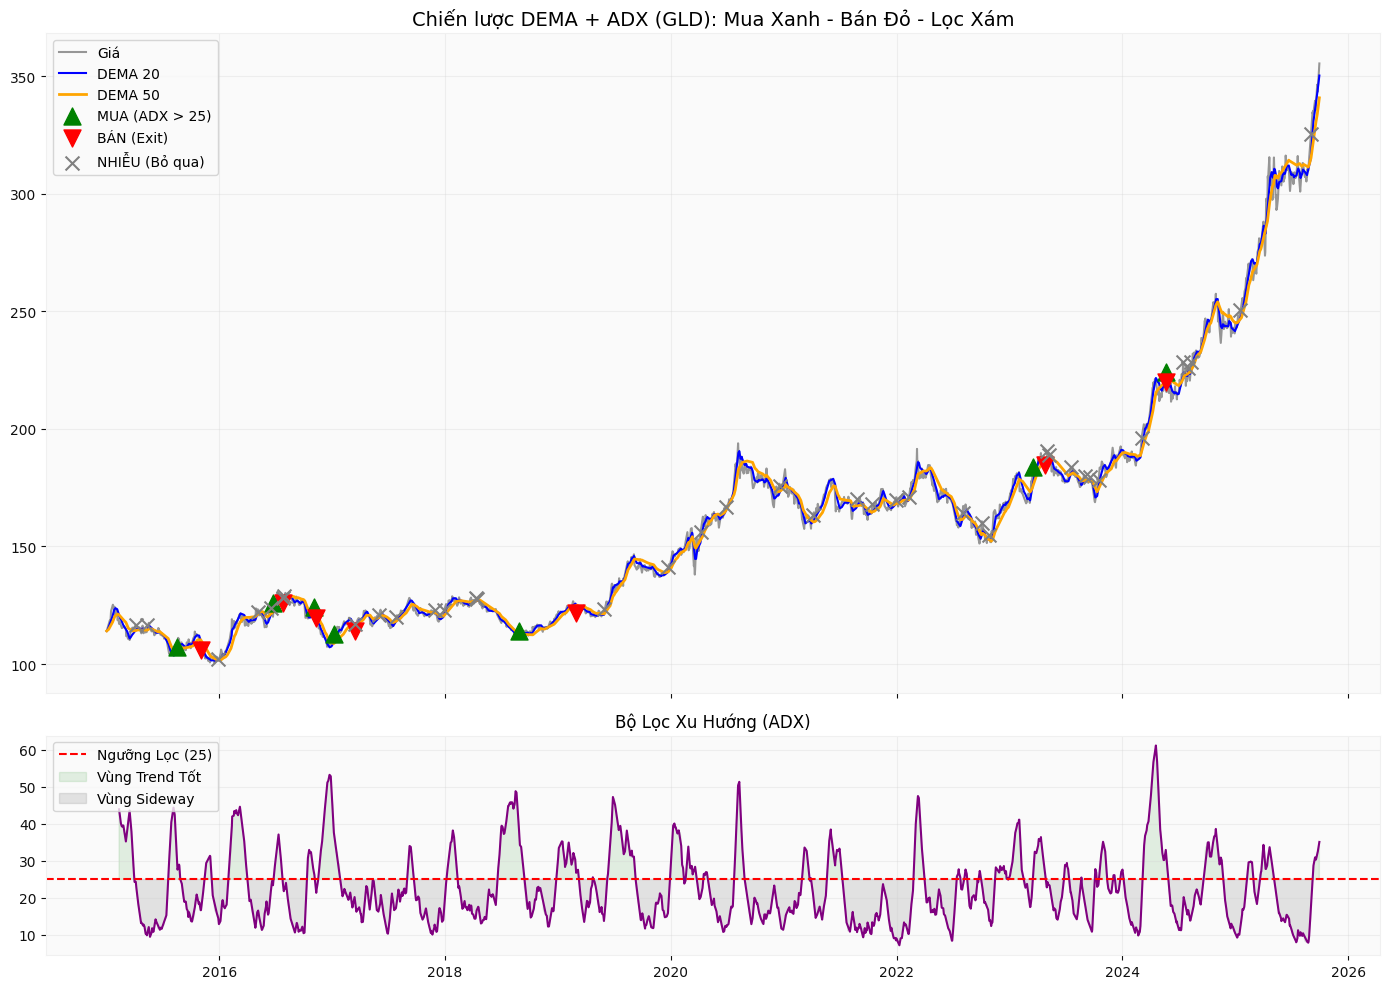

In [824]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# --- 1. CÁC HÀM TÍNH TOÁN (Giữ nguyên) ---
def calculate_dema(series, span):
    ema1 = series.ewm(span=span, adjust=False).mean()
    ema2 = ema1.ewm(span=span, adjust=False).mean()
    return 2 * ema1 - ema2

def calculate_adx_wilder(df, window=14):
    data = df.copy()
    data.columns = data.columns.str.lower()
    data['tr'] = np.maximum(data['high'] - data['low'],
                            np.maximum(abs(data['high'] - data['close'].shift(1)),
                                       abs(data['low'] - data['close'].shift(1))))
    def smooth(s, n): return s.ewm(alpha=1/n, adjust=False, min_periods=n).mean()
    data['tr_s'] = smooth(data['tr'], window)
    data['up'] = data['high'] - data['high'].shift(1)
    data['down'] = data['low'].shift(1) - data['low']
    data['+dm'] = np.where((data['up'] > data['down']) & (data['up'] > 0), data['up'], 0)
    data['-dm'] = np.where((data['down'] > data['up']) & (data['down'] > 0), data['down'], 0)
    data['+dm_s'] = smooth(data['+dm'], window)
    data['-dm_s'] = smooth(data['-dm'], window)
    data['dx'] = 100 * abs((data['+dm_s']/data['tr_s']) - (data['-dm_s']/data['tr_s'])) / ((data['+dm_s']/data['tr_s']) + (data['-dm_s']/data['tr_s']))
    data['adx'] = smooth(data['dx'], window)
    return data

# --- 2. CHIẾN LƯỢC CÓ VẼ ĐIỂM BÁN ---
def strategy_plot_sell_signals(df, start_date='2022-01-01'):
    # Tính chỉ báo
    df = calculate_adx_wilder(df)
    df['dema_20'] = calculate_dema(df['close'], 20)
    df['dema_50'] = calculate_dema(df['close'], 50)

    signals = np.zeros(len(df))
    position = 0
    filtered_signals = [] # Lưu các điểm bị lọc bỏ

    dema_20 = df['dema_20'].values
    dema_50 = df['dema_50'].values
    adx = df['adx'].values
    close = df['close'].values

    for i in range(1, len(df)):
        if np.isnan(dema_50[i]) or np.isnan(adx[i]): continue

        # Điều kiện
        cross_up = (dema_20[i] > dema_50[i]) and (dema_20[i-1] <= dema_50[i-1])
        cross_down = (dema_20[i] < dema_50[i]) and (dema_20[i-1] >= dema_50[i-1])
        strong_trend = adx[i] > 25

        if position == 0:
            if cross_up:
                if strong_trend:
                    position = 1 # MUA
                else:
                    filtered_signals.append((df.index[i], close[i])) # BỎ QUA
        elif position == 1:
            if cross_down:
                position = 0 # BÁN

        signals[i] = position

    df['Signal'] = signals

    # --- VẼ BIỂU ĐỒ ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Chart 1: Giá, DEMA và các Tín hiệu
    ax1.set_title(f'Chiến lược DEMA + ADX ({ticker}): Mua Xanh - Bán Đỏ - Lọc Xám', fontsize=14)
    ax1.plot(df.index, df['close'], color='black', alpha=0.4, label='Giá')
    ax1.plot(df.index, df['dema_20'], color='blue', linewidth=1.5, label='DEMA 20')
    ax1.plot(df.index, df['dema_50'], color='orange', linewidth=2, label='DEMA 50')

    # Lấy tọa độ Mua / Bán
    buys = df[df['Signal'].diff() == 1]
    sells = df[df['Signal'].diff() == -1]

    # Vẽ Mua (Xanh)
    ax1.scatter(buys.index, buys['close'], marker='^', color='green', s=150, zorder=5, label='MUA (ADX > 25)')

    # Vẽ Bán (Đỏ) - Phần bạn yêu cầu thêm
    ax1.scatter(sells.index, sells['close'], marker='v', color='red', s=150, zorder=5, label='BÁN (Exit)')

    # Vẽ Tín hiệu bị Lọc (Xám)
    if filtered_signals:
        x_filt = [x[0] for x in filtered_signals]
        y_filt = [x[1] for x in filtered_signals]
        ax1.scatter(x_filt, y_filt, marker='x', color='gray', s=100, zorder=5, label='NHIỄU (Bỏ qua)')

    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)

    # Chart 2: ADX
    ax2.set_title('Bộ Lọc Xu Hướng (ADX)')
    ax2.plot(df.index, df['adx'], color='purple')
    ax2.axhline(25, color='red', linestyle='--', label='Ngưỡng Lọc (25)')

    # Tô màu vùng Trend
    ax2.fill_between(df.index, df['adx'], 25, where=(df['adx'] >= 25), color='green', alpha=0.1, label='Vùng Trend Tốt')
    ax2.fill_between(df.index, df['adx'], 25, where=(df['adx'] < 25), color='gray', alpha=0.2, label='Vùng Sideway')

    ax2.legend(loc='upper left')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Chạy thử
strategy_plot_sell_signals(df, start_date='2022-01-01')

1. Nhóm "Trend Bền Vững"
- Mã: QQQ (Nasdaq 100 - Công nghệ Mỹ), NVDA (Nvidia).
- Đặc tính: Xu hướng tăng dài hạn, rõ ràng, ít nhiễu.
- Kỳ vọng: Chiến lược phải kiếm được lợi nhuận cao (gần bằng Buy & Hold). Nếu chiến lược thua ở đây thì vứt đi.

2. Nhóm "Biến Động"
- Mã: BTC-USD (Bitcoin), TSLA (Tesla).
- Đặc tính: Tăng sốc, giảm sâu (chia 3, chia 5).
- Mục tiêu test: Kiểm tra khả năng Cắt lỗ/Thoát hàng.
- Câu hỏi: Năm 2022 (Downtrend), chiến lược có giúp bạn cầm tiền đứng ngoài không? Hay vẫn lao vào bắt dao rơi?

3. Nhóm "Sideways" (Test bộ lọc ADX)
- Mã: EURUSD=X (Tỷ giá Euro/Đô la), GLD (Vàng).
- Đặc tính: Đi ngang trong biên độ hẹp nhiều năm trời. Cắt lên cắt xuống liên tục (Whipsaw).
- Mục tiêu test: Kiểm tra hiệu quả của ADX Filter.
- Kỳ vọng: Số lượng lệnh mua phải RẤT ÍT. Lợi nhuận có thể thấp hoặc hòa vốn, nhưng Max Drawdown phải thấp. Nếu ở đây mà lỗ nặng -> Bộ lọc ADX vô dụng.

4. Nhóm "Bear Market/Suy thoái" (Test khả năng phòng thủ)
- Mã: VNM (ETF Việt Nam - đại diện VNINDEX), BABA (Alibaba).
- Đặc tính: Có những chu kỳ giảm giá kéo dài (Downtrend) hoặc đi ngang giảm dần.
- Kỳ vọng: Chiến lược phải giữ được tiền (Cash is King). Đường cong vốn phải đi ngang, không được cắm đầu xuống.

In [825]:
import pandas as pd
import numpy as np
import yfinance as yf

# --- 1. HÀM TÍNH TOÁN HIỆU SUẤT (PERFORMANCE METRICS) ---
def print_comparison_report(df_result, benchmark_col='close'):
    """
    Tính toán và so sánh hiệu quả giữa Chiến lược và Buy & Hold.
    """
    # --- A. TÍNH CHỈ SỐ CHIẾN LƯỢC (STRATEGY) ---
    strat_cum = df_result['Cum']
    strat_total_ret = strat_cum.iloc[-1] - 1

    # CAGR (Tăng trưởng kép hàng năm)
    days = (df_result.index[-1] - df_result.index[0]).days
    strat_cagr = (strat_cum.iloc[-1]) ** (365.25 / days) - 1 if days > 0 else 0

    # Max Drawdown (Rủi ro sụt giảm tối đa)
    strat_roll_max = strat_cum.cummax()
    strat_dd = (strat_cum / strat_roll_max) - 1
    strat_mdd = strat_dd.min()

    # Sharpe Ratio (Lợi nhuận trên rủi ro)
    strat_daily_ret = strat_cum.pct_change().fillna(0)
    if strat_daily_ret.std() > 0:
        strat_sharpe = (strat_daily_ret.mean() / strat_daily_ret.std()) * np.sqrt(252)
    else:
        strat_sharpe = 0

    # Số lệnh & Win Rate
    if 'Signal' in df_result.columns:
        trades = df_result['Signal'].diff().fillna(0)
        # Lấy giá đóng lệnh để tính win rate (ước lượng)
        closes = df_result.loc[trades == -1, 'close']
        opens = df_result.loc[trades == 1, 'close']
        # Cắt cho bằng nhau
        n = min(len(closes), len(opens))
        wins = sum(closes.values[:n] > opens.values[:n])
        num_trades = len(opens)
        win_rate = wins / n if n > 0 else 0
    else:
        num_trades = 0
        win_rate = 0

    # --- B. TÍNH CHỈ SỐ BENCHMARK (BUY & HOLD) ---
    # Giả lập mua từ đầu và giữ nguyên đến cuối
    bnh_cum = df_result[benchmark_col] / df_result[benchmark_col].iloc[0]
    bnh_total_ret = bnh_cum.iloc[-1] - 1
    bnh_cagr = (bnh_cum.iloc[-1]) ** (365.25 / days) - 1 if days > 0 else 0

    bnh_roll_max = bnh_cum.cummax()
    bnh_dd = (bnh_cum / bnh_roll_max) - 1
    bnh_mdd = bnh_dd.min()

    bnh_daily_ret = bnh_cum.pct_change().fillna(0)
    if bnh_daily_ret.std() > 0:
        bnh_sharpe = (bnh_daily_ret.mean() / bnh_daily_ret.std()) * np.sqrt(252)
    else:
        bnh_sharpe = 0

    # --- C. IN BẢNG SO SÁNH ---
    print("\n" + "="*75)
    print(f"{'CHỈ SỐ (METRIC)':<30} | {'CHIẾN LƯỢC (Strategy)':<20} | {'THỊ TRƯỜNG (Buy&Hold)':<20}")
    print("="*75)
    print(f"{'1. Tổng Lợi Nhuận (Total Ret)':<30} | {strat_total_ret:>19.2%} | {bnh_total_ret:>19.2%}")
    print(f"{'2. Tăng trưởng/năm (CAGR)':<30} | {strat_cagr:>19.2%} | {bnh_cagr:>19.2%}")
    print(f"{'3. Rủi ro tối đa (Max Drawdown)':<30} | {strat_mdd:>19.2%} | {bnh_mdd:>19.2%}")
    print(f"{'4. Sharpe Ratio (Hiệu quả)':<30} | {strat_sharpe:>19.2f} | {bnh_sharpe:>19.2f}")
    print("-" * 75)
    print(f"{'5. Số lệnh đã thực hiện':<30} | {int(num_trades):>19} | {'N/A':>19}")
    print(f"{'6. Tỉ lệ thắng (Win Rate)':<30} | {win_rate:>19.2%} | {'N/A':>19}")
    print("="*75)

    # Đánh giá nhanh
    print("\n*** ĐÁNH GIÁ NHANH ***")
    if strat_sharpe > bnh_sharpe:
        print("✅ CHIẾN LƯỢC HIỆU QUẢ: Bạn có lợi nhuận tốt hơn trên mỗi đơn vị rủi ro so với thị trường.")
    else:
        print("⚠️ CHIẾN LƯỢC CẦN CẢI THIỆN: Mua và nắm giữ (Buy & Hold) đang cho kết quả tốt hơn.")

    if strat_mdd > bnh_mdd: # Lưu ý: MDD là số âm, lớn hơn nghĩa là ít âm hơn (ví dụ -10% > -30%)
        print("✅ QUẢN TRỊ RỦI RO TỐT: Bot giúp bạn tránh được những cú sập sâu của thị trường.")

# --- D. CHẠY THỬ VỚI DỮ LIỆU THẬT ---
# (Đảm bảo bạn đã có hàm calculate_... và strategy_... từ trước)
try:
    # Ví dụ chạy với NVDA
    df_test = yf.download('NVDA', start='2020-01-01', progress=False)
    if isinstance(df_test.columns, pd.MultiIndex): df_test.columns = df_test.columns.get_level_values(0)
    df_test.columns = df_test.columns.str.lower()

    # --- CHẠY CHIẾN LƯỢC ĐỂ CÓ KẾT QUẢ ---
    # (Copy lại phần logic DEMA+ADX rút gọn vào đây để code tự chạy được luôn)

    # 1. Tính chỉ báo
    df = df_test.copy()
    # ... (Giả sử bạn đã chạy hàm tính toán ở bước trước) ...
    # Để code chạy ngay lập tức, mình viết lại đoạn tính toán nhanh ở đây:

    # ADX
    df['tr'] = np.maximum(df['high'] - df['low'], np.maximum(abs(df['high'] - df['close'].shift(1)), abs(df['low'] - df['close'].shift(1))))
    def sm(s): return s.ewm(alpha=1/14, adjust=False).mean()
    df['adx'] = sm(100 * abs(sm(df['high']-df['high'].shift(1)) - sm(df['low'].shift(1)-df['low'])) / sm(df['tr'])) # ADX nhanh (gần đúng)

    # DEMA
    def dema(s, n): return 2*s.ewm(span=n).mean() - s.ewm(span=n).mean().ewm(span=n).mean()
    df['dema_20'] = dema(df['close'], 20)
    df['dema_50'] = dema(df['close'], 50)

    # Logic
    sig = np.zeros(len(df))
    pos = 0
    for i in range(1, len(df)):
        if df['dema_20'].iloc[i] > df['dema_50'].iloc[i] and df['adx'].iloc[i] > 25: pos = 1
        elif df['dema_20'].iloc[i] < df['dema_50'].iloc[i]: pos = 0
        sig[i] = pos

    df['Signal'] = sig
    df['Ret'] = df['Signal'].shift(1) * df['close'].pct_change()

_IncompleteInputError: incomplete input (2712451635.py, line 119)

In [792]:
! git add .
! git commit -m "Update MA"
! git push


On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean


Everything up-to-date
